In [13]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from src.few_shot_learning import load_cinic10, calculate_accuracy, plot_confusion_matrix

class FewShotResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(FewShotResNet, self).__init__()
        self.backbone = models.resnet18(weights="IMAGENET1K_V1")  # Load pretrained model
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)  # Replace last layer
    
    def forward(self, x):
        return self.backbone(x)

In [6]:
torch.hub.set_dir("../../models")

In [25]:
def train_few_shot(model, dataloader, epochs=10, lr=0.001):
    for param in model.backbone.parameters():
        param.requires_grad = False  # Freeze all layers

    for param in model.backbone.fc.parameters():
        param.requires_grad = True  # Unfreeze final classifier
        
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in dataloader:  # Load few-shot dataset
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}")

In [26]:
data_dir = "../../data"
dataloader = load_cinic10(data_dir, few_shot_per_class=100)
model = FewShotResNet()
train_few_shot(model, dataloader, epochs=30)

Epoch [1/30], Loss: 148.8213
Epoch [2/30], Loss: 128.8392
Epoch [3/30], Loss: 121.4503
Epoch [4/30], Loss: 115.2370
Epoch [5/30], Loss: 114.4384
Epoch [6/30], Loss: 111.4957
Epoch [7/30], Loss: 108.9263
Epoch [8/30], Loss: 106.9434
Epoch [9/30], Loss: 106.4654
Epoch [10/30], Loss: 105.9665
Epoch [11/30], Loss: 105.6373
Epoch [12/30], Loss: 102.8272
Epoch [13/30], Loss: 101.9572
Epoch [14/30], Loss: 100.6260
Epoch [15/30], Loss: 102.1116
Epoch [16/30], Loss: 103.9800
Epoch [17/30], Loss: 98.9407
Epoch [18/30], Loss: 100.7778
Epoch [19/30], Loss: 100.8372
Epoch [20/30], Loss: 98.9203
Epoch [21/30], Loss: 102.3175
Epoch [22/30], Loss: 97.9839
Epoch [23/30], Loss: 95.2465
Epoch [24/30], Loss: 98.1086
Epoch [25/30], Loss: 95.8585
Epoch [26/30], Loss: 96.4113
Epoch [27/30], Loss: 99.6888
Epoch [28/30], Loss: 97.8201
Epoch [29/30], Loss: 95.6011
Epoch [30/30], Loss: 97.4142


In [27]:
train_accuracy = calculate_accuracy(model, data_dir, split='train')

Accuracy on train set: 28.43%


In [28]:
test_accuracy = calculate_accuracy(model, data_dir, split='test')

Accuracy on test set: 27.56%


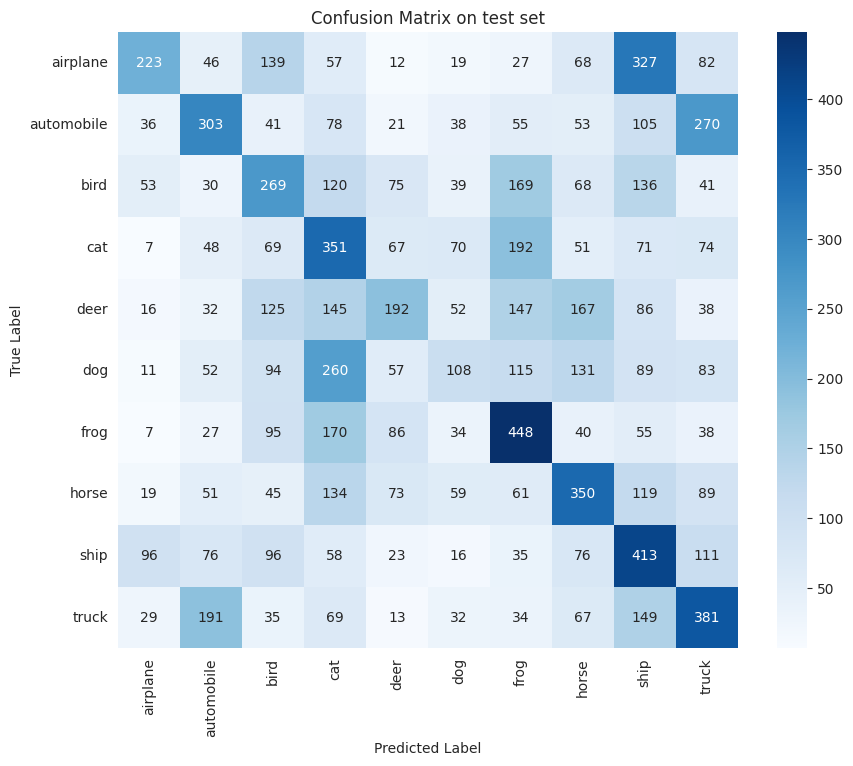

In [16]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(model, data_dir, split='test', class_names=class_names)